In [1]:
import cv2
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
perform_pca = False

# kmeans clusters
num_clusters = 10

In [3]:
import os
image_paths = ["./index/" + i for i in os.listdir("./index")][:200]

In [4]:
# Compute features in all images from database

des_list = []
for path in image_paths:
    image = cv2.imread(path)
    surf = cv2.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(image,None)
    for row in range(des.shape[0]):
        des[row] = des[row]/np.linalg.norm(des[row])
    des_list.append((path, des))

data_size = len(des_list)

descriptors = des_list[0][1]
for image, des in  des_list:
    descriptors = np.vstack((descriptors, des))
    

In [5]:
# PCA
if perform_pca:
    pca = PCA(n_components=40)
    pca.fit(descriptors) 
    reduced_descriptors = pca.transform(descriptors)
else:
    reduced_descriptors = descriptors

In [6]:
# Cluster the descriptors from the images in the database

kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit(reduced_descriptors)

# code_book = kmeans.cluster_centers_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
# Assign each descriptor in database and query image to the closest cluster
image_features = np.zeros((data_size, num_clusters))
for i in range(data_size):
    if perform_pca:
        pred = kmeans.predict(pca.transform(des_list[i][1]))
    else:
        pred = kmeans.predict(des_list[i][1])
    for k in range(len(pred)):
        image_features[i][pred[k]] += 1

In [8]:
# Build an inverted file index
inverted_file_index = [[] for _ in range(num_clusters)]
for i in range(data_size):
    for k in range(num_clusters):
        if(image_features[i][k] > 2):
            inverted_file_index[k].append(i)

In [9]:
# Compute a bag-of-words (BoW) vector for each retrieved image and query.
# This vector just counts the number of occurrences of each word. It has as
# many dimensions as there are visual words. Weight the vector with tf-idf.

total_counts = np.count_nonzero( (image_features > 0), axis = 0)
# add 1 to avoid Nan
idf = np.log((1.0*data_size+1) / (1.0*total_counts + 1))

weighted_features = image_features * idf.reshape(1, -1)

for row in range(weighted_features.shape[0]):
    weighted_features[row] = weighted_features[row]/(np.linalg.norm(weighted_features[row]) + 1e-7)
# weighted_features, idf

/home/yurina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [15]:
# For a query image, lookup all the visual words in the inverted file index to
# get a list of images that share at least one visual word with the query
def get_candidates(query_image):
    kp, des = surf.detectAndCompute(query_image,None)
    if perform_pca:
        pred = kmeans.predict(pca.transform(des) )
    else:
        pred = kmeans.predict(des)
    query_features = np.zeros((1, num_clusters))

    for k in range(len(pred)):
        query_features[0][pred[k]] += 1

    candidates = []
    for i in range(num_clusters):
        if(query_features[0][i] > 2):
            candidates.extend(inverted_file_index[i])
    
    candidates = list(set(candidates))
    return query_features, candidates

In [16]:
# Compute similarity between query BoW vector and all retrieved image BoW
# vectors. Sort (highest to lowest). Take top K most similar images
def getTopCandidates(top_k, query_features, candidates):
    queryIdf = idf * query_features
    queryIdf /= (np.linalg.norm(queryIdf) + 1e-7)
    
    # take candidate features
    candidate_features = weighted_features[candidates]

    similarity = queryIdf.reshape(1, -1) @ candidate_features.T
    # get top k (large to small)
    indices = np.argsort(-similarity)[0:top_k]
    return np.array([indices[0][0:top_k]])

In [17]:
# candidates: image index of candidates
query_image = cv2.imread("./c796b2c905f94f71.jpg")

query_features, candidates = get_candidates(query_image)

top_k = 5
# image index of top k candidates
top_k_candidates = getTopCandidates(top_k, query_features, candidates)[0]

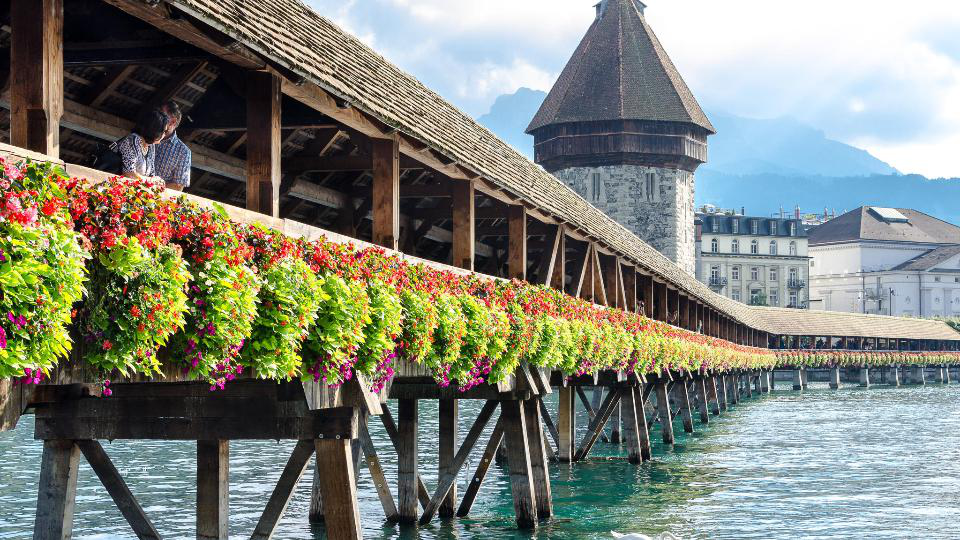

In [18]:
# query image
Image.open('c796b2c905f94f71.jpg')

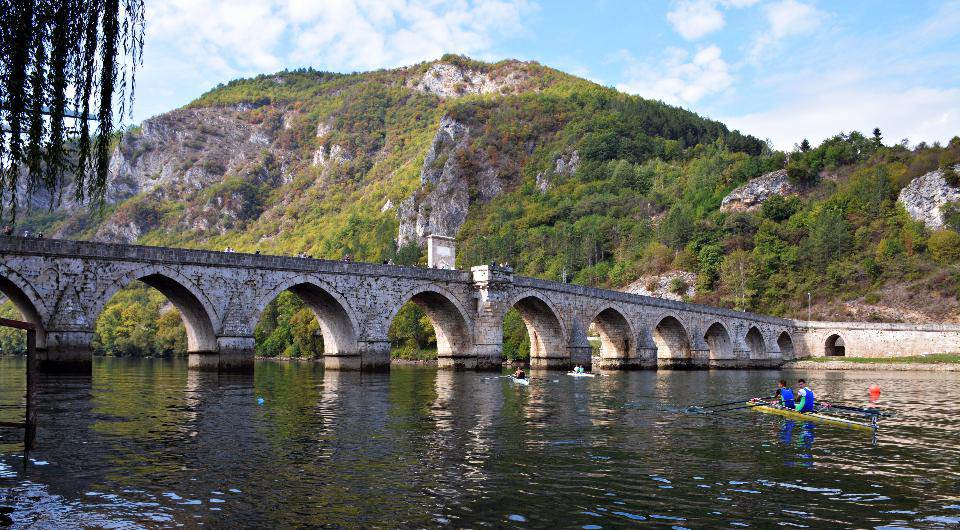

In [22]:
# top candidates
Image.open(image_paths[top_k_candidates[0]])

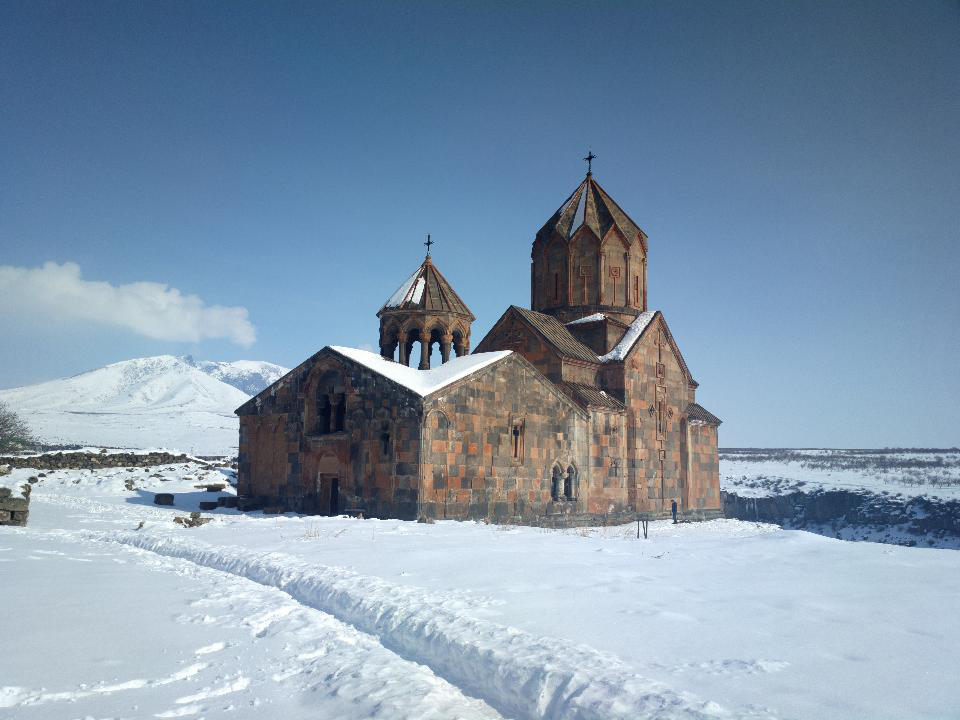

In [21]:
from PIL import Image
Image.open(image_paths[top_k_candidates[2]])